#Transcripts Insights Task - Bronnie Davies

##Set Up

In [1]:
!pip install langchain langchain_openai

In [2]:
from google.colab import userdata
import os
from typing import Optional
from pydantic import BaseModel, Field
from typing import Optional
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score, accuracy_score
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

# Download stopwords if not already downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

## Initialize LLM Parameters

##Define Schema

In [4]:
# Define the schema that will be used to get the structured output from the LLM
class TranscriptInsights(BaseModel):
    """Insights from a call transcript between a health insurance agent and a customer."""
    # Define field to extract sentiment
    sentiment: str = Field(default=None, description="The customers sentiment during the call: positive, negative or neutral")
    # Define field to extract outcome
    call_outcome: str = Field(default=None, description="The outcome of the call: issue resolved or follow-up action needed")

##Define Prompt

In [5]:
# Define the prompt that will be supplied to the LLM
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert extraction algorithm. Only extract relevant information from the text. If you do not know the value of an attribute asked to extract, return null for the attribute's value."
        ),
        ("human", "{text}"),
    ]
)

In [6]:
# Define the LLM to be used
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, max_retries=5, timeout=5)
# Combine LLM, prompt and schema
runnable = prompt | llm.with_structured_output(schema=TranscriptInsights)

## Query OpenAI

In [7]:
# assign directory
directory = '/content/drive/MyDrive/AXA/Data Science Manager Interview Task/transcripts_v2'
# iterate over files in the directory
results = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    with open(f, 'r') as file:
        text = file.read()
    # Get structured output for transcript
    output = runnable.invoke({"text": text})
    # Append to list
    results.append(
        {
            "transcript_id": filename,
            "sentiment": output.sentiment,
            "outcome": output.call_outcome
        }
    )
# Output results in a dataframe
df = pd.DataFrame(results)

In [8]:
df

,transcript_id,sentiment,outcome
0,transcript_104.txt,negative,follow-up action needed
1,transcript_59.txt,negative,follow-up action needed
2,transcript_114.txt,positive,issue resolved
3,transcript_4.txt,positive,issue resolved
4,transcript_39.txt,None,None
...,...,...,...
211,transcript_213.txt,negative,follow-up action needed
212,transcript_158.txt,positive,issue resolved
213,transcript_165.txt,negative,follow-up action needed
214,transcript_169.txt,neutral,issue resolved


## Dummy Ground Truth Creation
For illustration I have made a fake ground truth to enable the calculation of some evaluation metrics. In a real scenario a number of transcripts could be sampled and the real ground truth for them established to enable this.

### Create sentiment ground truth

In [9]:
# Encode sentiment into ordered numeric labels
ordered_sentiment = ['negative', 'neutral', 'positive']
sentiment_mapping = {label: idx for idx, label in enumerate(ordered_sentiment)}
df['encoded_sentiment'] = df['sentiment'].map(sentiment_mapping)

# Add noise to the numeric labels, but preserve the order
noise_factor = 1
df['noisy_sentiment'] = df['encoded_sentiment'] + np.random.uniform(-noise_factor, noise_factor, size=len(df))

# Round the noisy class to the nearest valid label
df['noisy_sentiment_rounded'] = df['noisy_sentiment'].round().astype("float64")

# Ensure noisy values stay within the valid label range
df['noisy_sentiment_rounded'] = np.clip(df['noisy_sentiment_rounded'], 0, len(ordered_sentiment) - 1)

# Map back to original sentiment
reverse_sentiment_mapping = {idx: label for label, idx in sentiment_mapping.items()}
df['true_sentiment'] = df['noisy_sentiment_rounded'].map(reverse_sentiment_mapping)

# Drop intermediate columns
df = df.drop(columns=['encoded_sentiment', 'noisy_sentiment', 'noisy_sentiment_rounded'])

df

,transcript_id,sentiment,outcome,true_sentiment
0,transcript_104.txt,negative,follow-up action needed,neutral
1,transcript_59.txt,negative,follow-up action needed,negative
2,transcript_114.txt,positive,issue resolved,positive
3,transcript_4.txt,positive,issue resolved,neutral
4,transcript_39.txt,None,None,NaN
...,...,...,...,...
211,transcript_213.txt,negative,follow-up action needed,negative
212,transcript_158.txt,positive,issue resolved,positive
213,transcript_165.txt,negative,follow-up action needed,negative
214,transcript_169.txt,neutral,issue resolved,positive


In [10]:
df[["true_sentiment", "sentiment"]].value_counts().sort_index()

true_sentiment  sentiment
negative        negative     72
                neutral       4
neutral         negative     22
                neutral       8
                positive     28
positive        neutral       3
                positive     71
Name: count, dtype: int64

### Create outcome ground truth

In [11]:
# Encode outcome into numeric labels
outcome_classes = ['issue resolved', 'follow-up action needed']
outcome_mapping = {label: idx for idx, label in enumerate(outcome_classes)}
df['encoded_outcome'] = df['outcome'].map(outcome_mapping)

# Add noise to the labels
noise_factor = 0.6
df['noisy_outcome'] = df['encoded_outcome'] + np.random.uniform(-noise_factor, noise_factor, size=len(df))

# Round the noisy class
df['noisy_outcome_rounded'] = df['noisy_outcome'].round().astype("float64")

# Clip to keep values binary (0 or 1)
df['noisy_outcome_rounded'] = np.clip(df['noisy_outcome_rounded'], 0, 1)

# Map back to outcome labels
reverse_outcome_mapping = {idx: label for label, idx in outcome_mapping.items()}
df['true_outcome'] = df['noisy_outcome_rounded'].map(reverse_outcome_mapping)

# Drop intermediate columns
df = df.drop(columns=['encoded_outcome', 'noisy_outcome', 'noisy_outcome_rounded'])

df

,transcript_id,sentiment,outcome,true_sentiment,true_outcome
0,transcript_104.txt,negative,follow-up action needed,neutral,follow-up action needed
1,transcript_59.txt,negative,follow-up action needed,negative,follow-up action needed
2,transcript_114.txt,positive,issue resolved,positive,issue resolved
3,transcript_4.txt,positive,issue resolved,neutral,issue resolved
4,transcript_39.txt,None,None,NaN,NaN
...,...,...,...,...,...
211,transcript_213.txt,negative,follow-up action needed,negative,follow-up action needed
212,transcript_158.txt,positive,issue resolved,positive,issue resolved
213,transcript_165.txt,negative,follow-up action needed,negative,follow-up action needed
214,transcript_169.txt,neutral,issue resolved,positive,issue resolved


In [12]:
df[["true_outcome", "outcome"]].value_counts().sort_index()

true_outcome             outcome                
follow-up action needed  follow-up action needed    105
                         issue resolved               4
issue resolved           follow-up action needed     11
                         issue resolved              88
Name: count, dtype: int64

## Calculate Evaluation Metrics

### Sentiment

In [13]:
# Confusion matrix
ordered_sentiment = ['negative', 'neutral', 'positive']
sentiment_mapping = {label: idx for idx, label in enumerate(ordered_sentiment)}
df['encoded_sentiment'] = df['sentiment'].map(sentiment_mapping)
df['encoded_true_sentiment'] = df['true_sentiment'].map(sentiment_mapping)

# Create confusion matrix
y_true = df['encoded_true_sentiment'].dropna()
y_pred = df['encoded_sentiment'].dropna()
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix with string labels
columns = ["predicted - " + sent for sent in ordered_sentiment]
pd.DataFrame(cm, index=ordered_sentiment, columns=columns).style.background_gradient(axis=1)

,predicted - negative,predicted - neutral,predicted - positive
negative,72,4,0
neutral,22,8,28
positive,0,3,71


In [14]:
# Compute Quadratic Weighted Kappa
qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')

print(f'Quadratic Weighted Kappa: {qwk}')

Quadratic Weighted Kappa: 0.8338658146964856


### Overall Outcome

In [15]:
# Confusion matrix
outcome_classes = ['issue resolved', 'follow-up action needed']
outcome_mapping = {label: idx for idx, label in enumerate(outcome_classes)}
df['encoded_outcome'] = df['outcome'].map(outcome_mapping)
df['encoded_true_outcome'] = df['true_outcome'].map(outcome_mapping)

# Create confusion matrix
y_true = df['encoded_true_outcome'].dropna()
y_pred = df['encoded_outcome'].dropna()
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix with string labels
columns = ["predicted - " + cls for cls in outcome_classes]
df_cm = pd.DataFrame(cm, index=outcome_classes, columns=columns).style.background_gradient(axis=None)
df_cm

,predicted - issue resolved,predicted - follow-up action needed
issue resolved,88,11
follow-up action needed,4,105


In [16]:
# Calculate classification metrics
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1:.2f}, Accuracy: {accuracy:.2f}')

F1 Score: 0.93, Accuracy: 0.93


## Data Insights

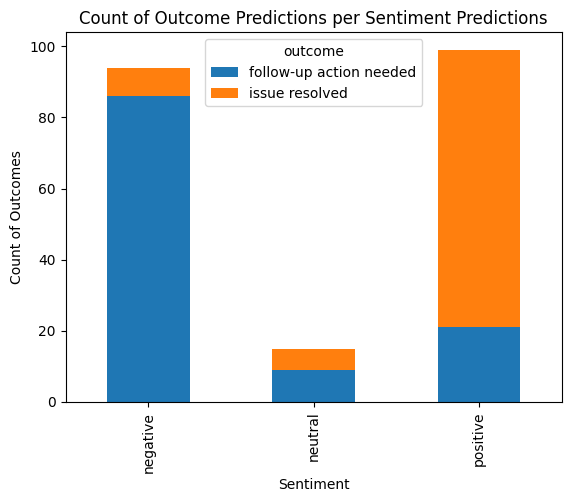

In [17]:
# Plot the relationship between overall outcome and sentiment

# Grouping by Sentiment and counting the occurrences of each outcome label
grouped = df[['sentiment', 'outcome']].groupby(['sentiment', 'outcome']).size().unstack(fill_value=0)

# Plotting the bar chart
grouped.plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count of Outcomes')
plt.title('Count of Outcome Predictions per Sentiment Predictions')
plt.show()


### Most Common Words

In [18]:
# Find the most common words in each transcript
def find_most_common_words(transcripts, top_n=10, custom_stopwords=None):
    '''A function that takes a list of strings and a custom list of stopwords
    and returns the top 10 occurring words in the list of strings
    (excluding nltks 'english' stopwords and any custom stopwords defined).'''

    # Initialize Counter to keep track of word frequencies across all transcripts
    combined_word_counts = Counter()

    # Prepare stop words and translator for punctuation removal
    stop_words = set(stopwords.words('english'))

    # Append custom stopwords if provided
    if custom_stopwords is not None:
        stop_words.update(custom_stopwords)

    translator = str.maketrans('', '', string.punctuation)

    # Process each transcript
    for transcript in transcripts:
        # Convert transcript to lowercase and remove punctuation
        clean_transcript = transcript.lower().translate(translator)

        # Split transcript into words
        words = clean_transcript.split()

        # Remove stop words
        words_filtered = [word for word in words if word not in stop_words]

        # Update combined word counts
        combined_word_counts.update(words_filtered)

      # Get the top N most common words across all transcripts
    most_common_words = combined_word_counts.most_common(top_n)

    # Convert to a DataFrame
    df_common_words = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

    return df_common_words

In [19]:
# The stopwords I have defined using business context
my_stopwords = ['member', 'customer', 'support', 'im', 'please', 'okay', 'mr', 'agent', 'ive', 'youre', 'policy', 'pa', 'dr', 'thats', 'need', 'ms', 'dont', 'see', 'get', 'going', 'claim', 'like']

In [20]:
def read_transcripts(directory, filenames):
    ''' A function that reads a list of files in a directory and
     appends them to a list which is returned.'''

    # Create empty list to populate with transcripts
    transcripts = []
    # Loop through the filesnames supplied
    for fname in filenames:
        # Create path by joining directory and a filename
        fpath = os.path.join(directory, fname)
        # Open the file
        with open(fpath, 'r') as f:
            # Read the file
            text = f.read()
        # Append the file to our list of transcripts
        transcripts.append(text)

    return transcripts

#### Sentiment

In [21]:
# Define transcript ids associated with LLM labelled negative transcripts
negative_transcript_ids = df[df['sentiment'] == 'negative']['transcript_id']
# Create a list of the relevant transcripts
negative_transcripts = read_transcripts(directory, negative_transcript_ids)
# Find the top 10 most common words in those transcripts
negative_common_words = find_most_common_words(negative_transcripts, top_n=10, custom_stopwords=my_stopwords)

In [22]:
# Define transcript ids associated with LLM labelled positive transcripts
positive_transcript_ids = df[df['sentiment'] == 'positive']['transcript_id']
# Create a list of the relevant transcripts
positive_transcripts = read_transcripts(directory, positive_transcript_ids)
# Find the top 10 most common words in those transcripts
positive_common_words = find_most_common_words(positive_transcripts, top_n=10, custom_stopwords=my_stopwords)

In [23]:
negative_common_words

,Word,Frequency
0,apologize,312
1,johnson,279
2,pause,200
3,understand,184
4,thank,183
5,mem123456,164
6,wilson,159
7,smith,150
8,service,145
9,calling,126


In [24]:
positive_common_words

,Word,Frequency
0,thank,425
1,emily,344
2,help,230
3,great,213
4,welcome,196
5,johnson,172
6,id,160
7,pause,150
8,copay,149
9,wilson,142


#### Outcome

In [25]:
# Define transcript ids associated with LLM labelled "follow-up action required" transcripts
action_transcript_ids = df[df['outcome'] == 'follow-up action needed']['transcript_id']
# Create a list of the relevant transcripts
action_transcripts = read_transcripts(directory, action_transcript_ids)
# Find the top 10 most common words in those transcripts
action_common_words = find_most_common_words(action_transcripts, top_n=10, custom_stopwords=my_stopwords)

In [26]:
# Define transcript ids associated with LLM labelled "issue resolved" transcripts
resolved_transcript_ids = df[df['outcome'] == 'issue resolved']['transcript_id']
# Create a list of the relevant transcripts
resolved_transcripts = read_transcripts(directory, resolved_transcript_ids)
# Find the top 10 most common words in those transcripts
resolved_common_words = find_most_common_words(resolved_transcripts, top_n=10, custom_stopwords=my_stopwords)

In [27]:
action_common_words

,Word,Frequency
0,apologize,338
1,johnson,313
2,thank,296
3,pause,229
4,mem123456,207
5,emily,201
6,understand,197
7,service,179
8,wilson,173
9,calling,164


In [28]:
resolved_common_words

,Word,Frequency
0,thank,361
1,emily,287
2,help,195
3,johnson,179
4,great,176
5,welcome,173
6,wilson,159
7,appointment,151
8,pause,148
9,id,147
